In [187]:
import torch.optim as optim
from pytorch_model_summary import summary

import matplotlib.pyplot as plt


In [201]:
# Import functions get_digits_loaders, get_mnist_loaders, get_labels 
%run Datasets.ipynb

# Import baseline RNN, reservoir RNN
%run Networks.ipynb

# Import the training and evaluation functions + their corresponding auxiliary function + all plot functions 
%run Operations.ipynb

# Import the evolutionary algorithm
%run EA.ipynb

### Define all parameters

In [205]:
# Data parameters
input_size_digits = 64  # 8 * 8 pixels
input_size_mnist = 784  # 28 * 28 pixels
n_labels = 10
batch_size= 50
train_loader_digits, val_loader_digits, test_loader_digits = get_digits_loaders(batch_size)
LABELS = get_labels()


# Network / Learning parameters
reservoir_size = 128 # for reservoir
n_hidden = 128 # for baseline
lr_SGD = 0.0001
momentum_SGD = 0.9
backprop_epochs = 5 # with backprop, only applicable in the evolutionairy approach. 
T = 5
loss_function = nn.NLLLoss(reduction='sum')
max_loss_iter = 10  # not really used yet


# EA parameters
population_size = 20
generations = 45 # epochs without backprop
mutate_opt = 'diff_mutation'  # Options: 'random_perturbation' , 'diff_mutation'
sample_dist = 'gaussian'       # If using random perturbation, options: 'gaussian' , 'uniform'
select_opt = 'accuracy'
select_mech = 'keep_k_best'   # Options: 'keep_k_best'= half of the parents , 'merge_all'
offspring_ratio = 1    # When mutating, create k times as much children as there are parents. 


# Run all models for same amount of time, but make a distinction in epochs for the evolutionairy approach .
n_epochs = backprop_epochs + generations

### Run baseline model

In [190]:
bl_model_digits = Baseline_RNN(input_size_digits, n_hidden, n_labels, T, dataset = 'Digits')
optimizer_digits = optim.SGD([p for p in bl_model_digits.parameters() if p.requires_grad == True], lr=lr_SGD, momentum=momentum_SGD)
loss_function = nn.NLLLoss(reduction='sum') # Mean is also possible.

trained_bl_digits = training(bl_model_digits, train_loader_digits, val_loader_digits, n_epochs, optimizer_digits, loss_function, max_loss_iter)

Training started for 50 epochs.
Epoch: 0 - Loss of: 0.22348874500819615 - Accuracy of: 93.71428680419922
Epoch: 1 - Loss of: 0.16384781496865408 - Accuracy of: 95.14286041259766
Epoch: 2 - Loss of: 0.21395541872297014 - Accuracy of: 93.14286041259766
Epoch: 3 - Loss of: 0.16508990458079748 - Accuracy of: 95.71428680419922
Epoch: 4 - Loss of: 0.12737535749162945 - Accuracy of: 96.57142639160156
Epoch: 5 - Loss of: 0.19038572856358119 - Accuracy of: 93.42857360839844
Epoch: 6 - Loss of: 0.13598449979509625 - Accuracy of: 96.0
Epoch: 7 - Loss of: 0.14514696700232368 - Accuracy of: 95.71428680419922
Epoch: 8 - Loss of: 0.13711592299597605 - Accuracy of: 96.28571319580078
Epoch: 9 - Loss of: 0.15588223661695208 - Accuracy of: 94.57142639160156
Epoch: 10 - Loss of: 0.13290570701871599 - Accuracy of: 96.0
Epoch: 11 - Loss of: 0.14336280958993095 - Accuracy of: 96.28571319580078
Epoch: 12 - Loss of: 0.1310463615826198 - Accuracy of: 96.0
Epoch: 13 - Loss of: 0.1518246190888541 - Accuracy of: 9

### Run EA Reservoir RNN 

In [206]:
# Initialize population - train by backprop for a few epochs. 
reservoir_set_digits = []
ea = EA(population_size, val_loader_digits, loss_function, input_size_digits, reservoir_size, n_labels)

for i in range(population_size):
    res_evo_digits = Reservoir_RNN(input_size_digits, reservoir_size, n_labels, T, dataset = 'Digits')
    optimizer_evo_digits = optim.SGD([p for p in res_evo_digits.parameters() if p.requires_grad == True], lr=lr_SGD, momentum=momentum_SGD)
    trained_evo_digits = training(res_evo_digits, train_loader_digits, val_loader_digits, backprop_epochs, optimizer_evo_digits, loss_function, max_loss_iter)
    reservoir_set_digits.append(trained_evo_digits)
        
# Initialize the population
new_pop = reservoir_set_digits

# Perform ea steps
for i in range(generations):
    new_pop = ea.step(new_pop, mutate_opt, select_opt, select_mech, offspring_ratio, sample_dist)

# Sort population after x amount of generations, based on accuracy or loss performance
if select_opt == 'accuracy':
    best_pop_digits = sorted(new_pop, key=lambda k: k['accuracy_results'][-1] , reverse=True) 
elif select_opt == 'loss':
    best_pop_digits = sorted(new_pop, key=lambda k: k['loss_results'][-1] , reverse=False)


Training started for 5 epochs.
Epoch: 0 - Loss of: 2.2493533761160713 - Accuracy of: 45.14285659790039
Epoch: 1 - Loss of: 2.1656934901646205 - Accuracy of: 60.57143020629883
Epoch: 2 - Loss of: 2.0830960954938615 - Accuracy of: 78.85713958740234
Epoch: 3 - Loss of: 2.0041996111188616 - Accuracy of: 84.85713958740234
Epoch: 4 - Loss of: 1.9294529070172992 - Accuracy of: 81.42857360839844
Training started for 5 epochs.
Epoch: 0 - Loss of: 2.2570926993233815 - Accuracy of: 21.14285659790039
Epoch: 1 - Loss of: 2.188043430873326 - Accuracy of: 64.57142639160156
Epoch: 2 - Loss of: 2.1188863699776785 - Accuracy of: 78.57142639160156
Epoch: 3 - Loss of: 2.052774331229074 - Accuracy of: 83.42857360839844
Epoch: 4 - Loss of: 1.9890016610281809 - Accuracy of: 85.42857360839844
Training started for 5 epochs.
Epoch: 0 - Loss of: 2.251637442452567 - Accuracy of: 48.28571319580078
Epoch: 1 - Loss of: 2.1731359427315846 - Accuracy of: 76.0
Epoch: 2 - Loss of: 2.0944524928501673 - Accuracy of: 78.0


Epoch: 5 - Loss of: 2.0869614955357143 - Accuracy of: 21.428571701049805
Epoch: 5 - Loss of: 2.153724343436105 - Accuracy of: 30.0
Epoch: 5 - Loss of: 2.544076690673828 - Accuracy of: 0.2857142984867096
Epoch: 5 - Loss of: 2.0489678519112724 - Accuracy of: 47.42856979370117
Epoch: 5 - Loss of: 2.140523005894252 - Accuracy of: 19.428571701049805
Epoch: 5 - Loss of: 2.050470232282366 - Accuracy of: 31.714284896850586
Epoch: 5 - Loss of: 2.5107769775390625 - Accuracy of: 0.5714285969734192
Epoch: 5 - Loss of: 2.084781494140625 - Accuracy of: 23.428571701049805
Epoch: 5 - Loss of: 2.042879398890904 - Accuracy of: 44.0
Epoch: 5 - Loss of: 2.126803196498326 - Accuracy of: 38.0
Epoch: 5 - Loss of: 2.077856641496931 - Accuracy of: 31.428571701049805
Epoch: 5 - Loss of: 2.0387991115025113 - Accuracy of: 33.71428680419922
Epoch: 5 - Loss of: 2.1161553301130023 - Accuracy of: 38.57143020629883
Epoch: 5 - Loss of: 2.135950622558594 - Accuracy of: 21.14285659790039
Epoch: 5 - Loss of: 2.12963747297

Epoch: 8 - Loss of: 4.721512145996094 - Accuracy of: 6.5714287757873535
Epoch: 8 - Loss of: 180.8834779575893 - Accuracy of: 14.285714149475098
Epoch: 8 - Loss of: 8.941025390625 - Accuracy of: 8.285714149475098
Epoch: 8 - Loss of: 1.3778074863978795 - Accuracy of: 61.71428680419922
Epoch: 8 - Loss of: 1.3778074863978795 - Accuracy of: 61.71428680419922
Epoch: 8 - Loss of: 2.0489678519112724 - Accuracy of: 47.42856979370117
Epoch: 8 - Loss of: 2.0489678519112724 - Accuracy of: 47.42856979370117
Epoch: 8 - Loss of: 2.0489678519112724 - Accuracy of: 47.42856979370117
Epoch: 8 - Loss of: 2.0489678519112724 - Accuracy of: 47.42856979370117
Epoch: 8 - Loss of: 1.9830510820661271 - Accuracy of: 47.14285659790039
Epoch: 8 - Loss of: 1.9830510820661271 - Accuracy of: 47.14285659790039
Epoch: 8 - Loss of: 2.042879398890904 - Accuracy of: 44.0
Epoch: 8 - Loss of: 2.042879398890904 - Accuracy of: 44.0
Epoch: 8 - Loss of: 69.24856305803571 - Accuracy of: 9.714285850524902
Epoch: 8 - Loss of: 8.732

Epoch: 11 - Loss of: 39118.77392857143 - Accuracy of: 10.0
Epoch: 11 - Loss of: 426330305.0971429 - Accuracy of: 11.428571701049805
Epoch: 11 - Loss of: 5945723.337142857 - Accuracy of: 9.428571701049805
Epoch: 11 - Loss of: 378411835.9771429 - Accuracy of: 7.142857074737549
Epoch: 11 - Loss of: 645271.7828571429 - Accuracy of: 8.285714149475098
Epoch: 11 - Loss of: 45.25115966796875 - Accuracy of: 5.4285712242126465
Epoch: 11 - Loss of: 3.7218346296037947 - Accuracy of: 11.428571701049805
Epoch: 11 - Loss of: 97790.575 - Accuracy of: 4.285714149475098
Epoch: 11 - Loss of: 55.29968052455357 - Accuracy of: 12.571428298950195
Epoch: 11 - Loss of: 1.5744093758719309 - Accuracy of: 80.85713958740234
Epoch: 11 - Loss of: 1.4104598781040736 - Accuracy of: 71.14286041259766
Epoch: 11 - Loss of: 1.4104598781040736 - Accuracy of: 71.14286041259766
Epoch: 11 - Loss of: 1.575771004813058 - Accuracy of: 68.0
Epoch: 11 - Loss of: 1.575771004813058 - Accuracy of: 68.0
Epoch: 11 - Loss of: 201092891.

Epoch: 13 - Loss of: 1.4104598781040736 - Accuracy of: 71.14286041259766
Epoch: 13 - Loss of: 1.4104598781040736 - Accuracy of: 71.14286041259766
Possible candidates for optimization
Epoch: 14 - Loss of: 2166189728.9142857 - Accuracy of: 10.285714149475098
Epoch: 14 - Loss of: 2.0936681692940846 - Accuracy of: 33.42856979370117
Epoch: 14 - Loss of: 1.491596200125558 - Accuracy of: 76.0
Epoch: 14 - Loss of: 2215753739.702857 - Accuracy of: 11.142857551574707
Epoch: 14 - Loss of: 154782955.52 - Accuracy of: 5.142857074737549
Epoch: 14 - Loss of: 750679443.7485714 - Accuracy of: 6.5714287757873535
Epoch: 14 - Loss of: 2.5268116760253907 - Accuracy of: 1.7142857313156128
Epoch: 14 - Loss of: 329451291.7942857 - Accuracy of: 10.0
Epoch: 14 - Loss of: 2753853264.457143 - Accuracy of: 12.285714149475098
Epoch: 14 - Loss of: 2.1523847307477677 - Accuracy of: 24.571428298950195
Epoch: 14 - Loss of: 1.5744093758719309 - Accuracy of: 80.85713958740234
Epoch: 14 - Loss of: 1.5744093758719309 - Acc

Epoch: 16 - Loss of: 1.5744093758719309 - Accuracy of: 80.85713958740234
Epoch: 16 - Loss of: 1.5744093758719309 - Accuracy of: 80.85713958740234
Epoch: 16 - Loss of: 1.5744093758719309 - Accuracy of: 80.85713958740234
Epoch: 16 - Loss of: 1.5744093758719309 - Accuracy of: 80.85713958740234
Epoch: 16 - Loss of: 1.5744093758719309 - Accuracy of: 80.85713958740234
Epoch: 16 - Loss of: 1.5744093758719309 - Accuracy of: 80.85713958740234
Epoch: 16 - Loss of: 1.5744093758719309 - Accuracy of: 80.85713958740234
Epoch: 16 - Loss of: 1.5744093758719309 - Accuracy of: 80.85713958740234
Epoch: 16 - Loss of: 1.5744093758719309 - Accuracy of: 80.85713958740234
Possible candidates for optimization
Epoch: 17 - Loss of: 2693002979775236.5 - Accuracy of: 4.857142925262451
Epoch: 17 - Loss of: 3596748699355.4287 - Accuracy of: 8.285714149475098
Epoch: 17 - Loss of: 1.511405487060547 - Accuracy of: 77.42857360839844
Epoch: 17 - Loss of: 2.0343802097865513 - Accuracy of: 35.42856979370117
Epoch: 17 - Los

Epoch: 19 - Loss of: 2.5266474620692517e+19 - Accuracy of: 9.428571701049805
Epoch: 19 - Loss of: 716904148295258.8 - Accuracy of: 8.571428298950195
Epoch: 19 - Loss of: 1.1136207369054821e+18 - Accuracy of: 17.428571701049805
Epoch: 19 - Loss of: 2.7313711690839077e+19 - Accuracy of: 14.285714149475098
Epoch: 19 - Loss of: 1.0258512146939042e+19 - Accuracy of: 7.142857074737549
Epoch: 19 - Loss of: 7.550776713124505e+19 - Accuracy of: 6.285714149475098
Epoch: 19 - Loss of: 4.569901621084644e+19 - Accuracy of: 9.428571701049805
Epoch: 19 - Loss of: 2.130728781563895 - Accuracy of: 32.28571319580078
Epoch: 19 - Loss of: 1.5744093758719309 - Accuracy of: 80.85713958740234
Epoch: 19 - Loss of: 1.5744093758719309 - Accuracy of: 80.85713958740234
Epoch: 19 - Loss of: 1.5744093758719309 - Accuracy of: 80.85713958740234
Epoch: 19 - Loss of: 1.5744093758719309 - Accuracy of: 80.85713958740234
Epoch: 19 - Loss of: 1.5744093758719309 - Accuracy of: 80.85713958740234
Epoch: 19 - Loss of: 1.574409

Epoch: 22 - Loss of: 1.9294529070172992 - Accuracy of: 81.42857360839844
Epoch: 22 - Loss of: 1.5744093758719309 - Accuracy of: 80.85713958740234
Epoch: 22 - Loss of: 1.5744093758719309 - Accuracy of: 80.85713958740234
Epoch: 22 - Loss of: 1.5744093758719309 - Accuracy of: 80.85713958740234
Epoch: 22 - Loss of: 1.5744093758719309 - Accuracy of: 80.85713958740234
Epoch: 22 - Loss of: 1.5744093758719309 - Accuracy of: 80.85713958740234
Epoch: 22 - Loss of: 1.5744093758719309 - Accuracy of: 80.85713958740234
Epoch: 22 - Loss of: 2.0947770254952567 - Accuracy of: 17.14285659790039
Epoch: 22 - Loss of: 6.727913153337997e+24 - Accuracy of: 11.142857551574707
Epoch: 22 - Loss of: 2.456982945033482 - Accuracy of: 1.1428571939468384
Epoch: 22 - Loss of: 2.074095982142857 - Accuracy of: 30.0
Epoch: 22 - Loss of: 8.266153094225575e+24 - Accuracy of: 6.857142925262451
Epoch: 22 - Loss of: 7.583969624417144e+24 - Accuracy of: 17.714284896850586
Epoch: 22 - Loss of: 4.0461619190454024e+24 - Accuracy

Epoch: 25 - Loss of: 2.3153810833959356e+29 - Accuracy of: 8.0
Epoch: 25 - Loss of: 1.3839888240138076e+28 - Accuracy of: 9.428571701049805
Epoch: 25 - Loss of: 4.97960279774366e+24 - Accuracy of: 9.142857551574707
Epoch: 25 - Loss of: 5.322368969959937e+24 - Accuracy of: 10.0
Epoch: 25 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 25 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 25 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 25 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 25 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 25 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 25 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 25 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 25 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 25 - Loss of: 1.9954210771833147 - Accuracy of: 83.1428604

Epoch: 27 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 27 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 27 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 27 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Possible candidates for optimization
Epoch: 28 - Loss of: 3.3773284633330813e+24 - Accuracy of: 11.142857551574707
Epoch: 28 - Loss of: 2.141225106375558 - Accuracy of: 27.714284896850586
Epoch: 28 - Loss of: 4.1833994757657995e+24 - Accuracy of: 9.714285850524902
Epoch: 28 - Loss of: 8.898263626260604e+32 - Accuracy of: 10.285714149475098
Epoch: 28 - Loss of: 1.0174917629989638e+34 - Accuracy of: 20.285715103149414
Epoch: 28 - Loss of: 2.6011540235821176e+28 - Accuracy of: 7.142857074737549
Epoch: 28 - Loss of: 5.708752633146704e+28 - Accuracy of: 6.0
Epoch: 28 - Loss of: 1.3020390069337903e+34 - Accuracy of: 10.285714149475098
Epoch: 28 - Loss of: 1.9954210771833147 - Accuracy of: 83.1428604125976

Epoch: 30 - Loss of: 2.1609937395368304 - Accuracy of: 17.714284896850586
Epoch: 30 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 30 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 30 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 30 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 30 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 30 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 30 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 30 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 30 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 30 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 30 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 30 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Possible candidates for optimization
Epoch: 31 - L

Epoch: 33 - Loss of: 2.019392743791853 - Accuracy of: 48.0
Epoch: 33 - Loss of: 1.27600547526652e+36 - Accuracy of: 4.285714149475098
Epoch: 33 - Loss of: 2.991353349315818e+24 - Accuracy of: 5.142857074737549
Epoch: 33 - Loss of: 2.1363306971958704 - Accuracy of: 33.42856979370117
Epoch: 33 - Loss of: nan - Accuracy of: 10.285714149475098
Epoch: 33 - Loss of: nan - Accuracy of: 10.285714149475098
Epoch: 33 - Loss of: inf - Accuracy of: 11.142857551574707
Epoch: 33 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 33 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 33 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 33 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 33 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 33 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 33 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 33 - Loss of: 1.995421

Epoch: 36 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 36 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 36 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 36 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 36 - Loss of: nan - Accuracy of: 10.285714149475098
Epoch: 36 - Loss of: nan - Accuracy of: 10.285714149475098
Epoch: 36 - Loss of: 2.5667590542430403e+24 - Accuracy of: 6.5714287757873535
Epoch: 36 - Loss of: nan - Accuracy of: 10.285714149475098
Epoch: 36 - Loss of: 2.4089613363329002e+24 - Accuracy of: 9.428571701049805
Epoch: 36 - Loss of: 2.039629167829241 - Accuracy of: 40.0
Epoch: 36 - Loss of: nan - Accuracy of: 10.285714149475098
Epoch: 36 - Loss of: nan - Accuracy of: 10.285714149475098
Epoch: 36 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 36 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 36 - Loss of: 1.9954210771833147 - Accuracy of

Epoch: 39 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 39 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 39 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 39 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 39 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 39 - Loss of: nan - Accuracy of: 10.285714149475098
Epoch: 39 - Loss of: 1.0652440954500366e+27 - Accuracy of: 11.142857551574707
Epoch: 39 - Loss of: nan - Accuracy of: 10.285714149475098
Epoch: 39 - Loss of: nan - Accuracy of: 10.285714149475098
Epoch: 39 - Loss of: nan - Accuracy of: 10.285714149475098
Epoch: 39 - Loss of: 2.822243719004798e+24 - Accuracy of: 13.714285850524902
Epoch: 39 - Loss of: 2.4802180480957032 - Accuracy of: 2.857142925262451
Epoch: 39 - Loss of: nan - Accuracy of: 10.285714149475098
Epoch: 39 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 39 - Loss of: 1.9954210771833147

Epoch: 42 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 42 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 42 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 42 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 42 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 42 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 42 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 42 - Loss of: 2.11623042515346 - Accuracy of: 38.0
Epoch: 42 - Loss of: nan - Accuracy of: 10.285714149475098
Epoch: 42 - Loss of: nan - Accuracy of: 10.285714149475098
Epoch: 42 - Loss of: nan - Accuracy of: 10.285714149475098
Epoch: 42 - Loss of: 2.4714616394042968 - Accuracy of: 2.2857143878936768
Epoch: 42 - Loss of: nan - Accuracy of: 10.285714149475098
Epoch: 42 - Loss of: nan - Accuracy of: 10.285714149475098
Epoch: 42 - Loss of: nan - Accuracy of: 10.285714149475098
Epo

Epoch: 45 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 45 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 45 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 45 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 45 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 45 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 45 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 45 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 45 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 45 - Loss of: nan - Accuracy of: 10.285714149475098
Epoch: 45 - Loss of: 2.566153804234096 - Accuracy of: 5.4285712242126465
Epoch: 45 - Loss of: nan - Accuracy of: 10.285714149475098
Epoch: 45 - Loss of: nan - Accuracy of: 10.285714149475098
Epoch: 45 - Loss of: 3.341220332138355e+24 - Accuracy of: 8.285714149475098
Epoch: 45 - Loss 

Epoch: 48 - Loss of: nan - Accuracy of: 10.285714149475098
Epoch: 48 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 48 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 48 - Loss of: nan - Accuracy of: 10.285714149475098
Epoch: 48 - Loss of: 1.9326107352120536 - Accuracy of: 87.42857360839844
Epoch: 48 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 48 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 48 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 48 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 48 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 48 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 48 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 48 - Loss of: 1.9954210771833147 - Accuracy of: 83.14286041259766
Epoch: 48 - Loss of: 1.4289047459193638 - Accuracy of: 78.85713958740234
Epoch:

### Run 1 Reservoir RNN without any EA optimization

In [192]:
res_model_digits = Reservoir_RNN(input_size_digits, reservoir_size, n_labels, T, dataset = 'Digits')
optimizer_digits = optim.SGD([p for p in res_model_digits.parameters() if p.requires_grad == True], lr=lr_SGD, momentum=momentum_SGD)
trained_res_digits = training(res_model_digits, train_loader_digits, val_loader_digits, n_epochs, optimizer_digits, loss_function, max_loss_iter)

Training started for 50 epochs.
Epoch: 0 - Loss of: 2.246818629673549 - Accuracy of: 57.42856979370117
Epoch: 1 - Loss of: 2.1640018572126114 - Accuracy of: 71.14286041259766
Epoch: 2 - Loss of: 2.0786637006487165 - Accuracy of: 80.57142639160156
Epoch: 3 - Loss of: 1.998658425467355 - Accuracy of: 85.71428680419922
Epoch: 4 - Loss of: 1.9239671543666295 - Accuracy of: 80.85713958740234
Epoch: 5 - Loss of: 1.8517856270926338 - Accuracy of: 88.57142639160156
Epoch: 6 - Loss of: 1.785709969656808 - Accuracy of: 83.42857360839844
Epoch: 7 - Loss of: 1.7217775399344308 - Accuracy of: 86.0
Epoch: 8 - Loss of: 1.6618924386160714 - Accuracy of: 86.85713958740234
Epoch: 9 - Loss of: 1.6054417637416294 - Accuracy of: 86.28571319580078
Epoch: 10 - Loss of: 1.5520510646275112 - Accuracy of: 88.0
Epoch: 11 - Loss of: 1.502511509486607 - Accuracy of: 88.28571319580078
Epoch: 12 - Loss of: 1.4550042942592076 - Accuracy of: 87.42857360839844
Epoch: 13 - Loss of: 1.4105983407156808 - Accuracy of: 86.8

### Plot the results

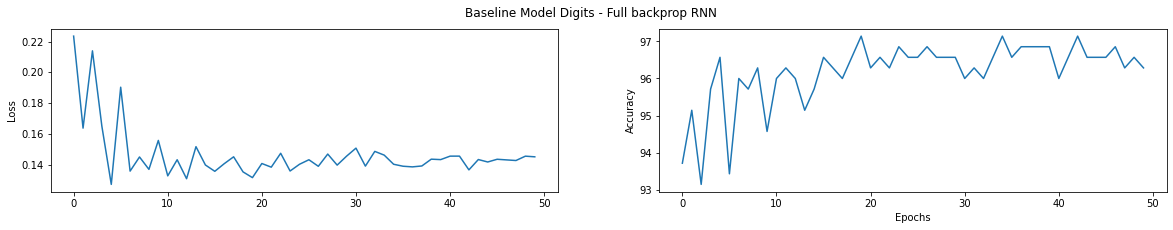

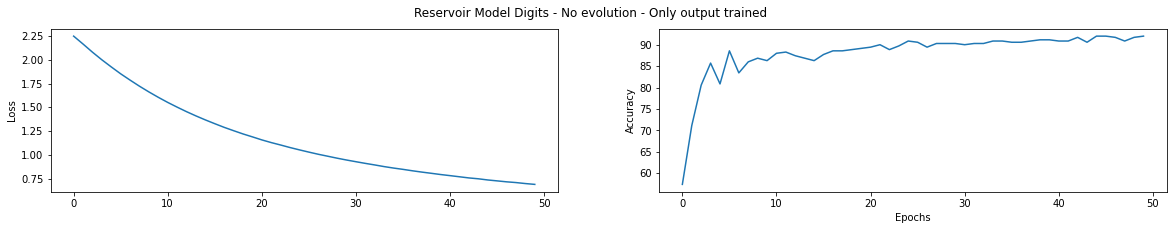

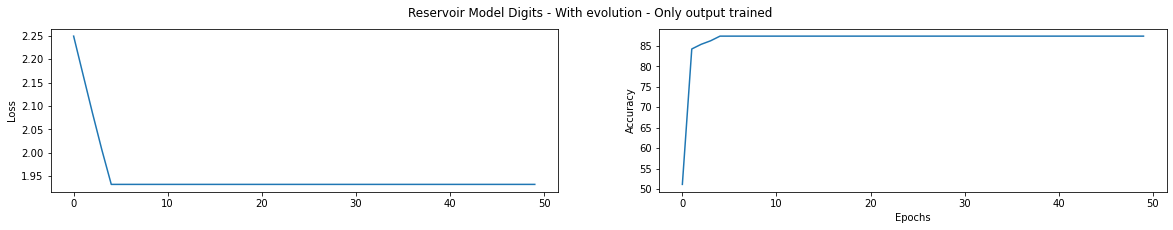

In [207]:
# Plot baseline - full backprop
plot_results(trained_bl_digits['epoch'], 
             trained_bl_digits['loss_results'], 
             trained_bl_digits['accuracy_results'],
            'Baseline Model Digits - Full backprop RNN')

# Plot reservoir - no evolution yet
plot_results(trained_res_digits['epoch'], 
             trained_res_digits['loss_results'], 
             trained_res_digits['accuracy_results'],
            'Reservoir Model Digits - No evolution - Only output trained')

# Plot reservoir - with evolution - best model
plot_results(best_pop_digits[0]['epoch'], 
             best_pop_digits[0]['loss_results'], 
             best_pop_digits[0]['accuracy_results'],
            'Reservoir Model Digits - With evolution - Only output trained')


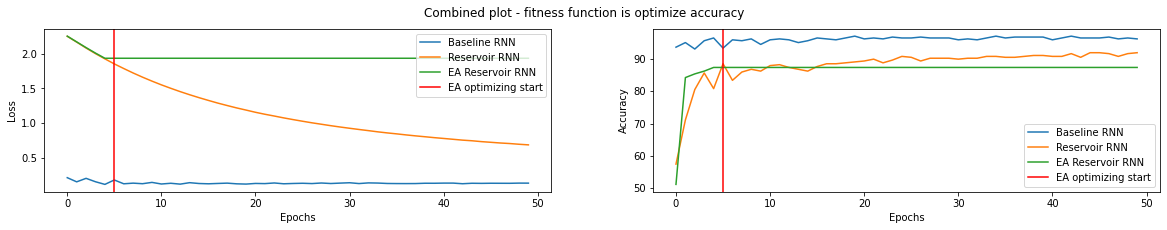

In [208]:
# Plot above plots in one plot
combined_plot_result(
            trained_bl_digits['epoch'],
            trained_bl_digits['loss_results'], 
            trained_bl_digits['accuracy_results'],
            trained_res_digits['loss_results'], 
            trained_res_digits['accuracy_results'],
            best_pop_digits[0]['loss_results'], 
            best_pop_digits[0]['accuracy_results'],
            border = backprop_epochs,
            label_bl = 'Baseline RNN',
            label_res = 'Reservoir RNN',
            label_evo = 'EA Reservoir RNN',
            title = 'Combined plot - fitness function is optimize accuracy')

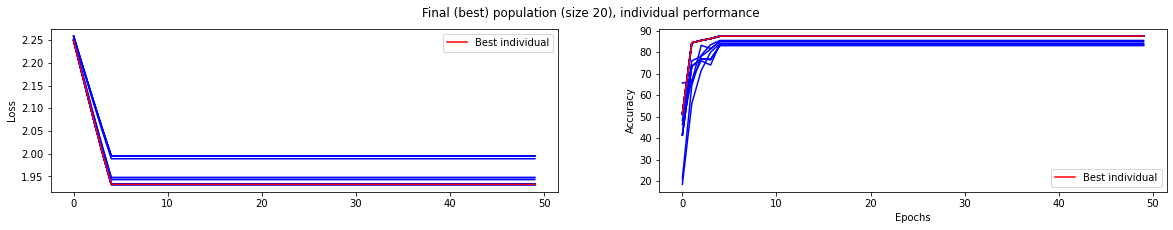

In [212]:
best_pop_plot(best_pop_digits, 
              best_pop_digits[0], 
              title='Final (best) population (size %s), individual performance' %(population_size))

### Overview of the models structure

In [143]:
# Baseline RNN model
print(summary(bl_model_digits, torch.zeros(1, 64), show_input=True, show_hierarchical=False))

# Reservoir RNN model
print(summary(res_model_digits, torch.zeros(1, 64), show_input=True, show_hierarchical=False))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Linear-1            [1, 128]          16,512          16,512
            Tanh-2            [1, 128]               0               0
          Linear-3            [1, 192]          24,704          24,704
            ReLU-4            [1, 128]               0               0
          Linear-5            [1, 192]          24,704          24,704
            ReLU-6            [1, 128]               0               0
          Linear-7            [1, 192]          24,704          24,704
            ReLU-8            [1, 128]               0               0
          Linear-9            [1, 192]          24,704          24,704
           ReLU-10            [1, 128]               0               0
         Linear-11            [1, 192]          24,704          24,704
           ReLU-12            [1, 128]               0               0
     

### Next: MNIST , will take a long time to process

In [204]:
# Load in digits data and perform training
# Takes a bit of time

#train_loader_mnist, val_loader_mnist, test_loader_mnist = get_mnist_loaders(batch_size=50)